<a href="https://colab.research.google.com/github/johnbunnyan/johnbunnyan.github.io/blob/main/reading/%5BHW26_Answer%5DWord2Vec_%EC%A0%95%EC%83%81%EA%B7%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**3. Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

### **필요 패키지 import**

In [1]:

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,575 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 32.6 MB/s 
     |████████████████████████████████| 465 kB 73.6 MB/s 


In [3]:
from tqdm import tqdm
# KoNLPy 한국어 처리 패키지
from konlpy.tag import Mecab,Twitter,Okt,Kkma 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### **데이터 전처리**



데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.

In [4]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

In [5]:
# Okt(Open Korean Text)는 트위터에서 만든 오픈소스 한국어 처리기인 twitter-korean-text를 이어받아 만들고 있는 프로젝트
tokenizer = Okt()

In [6]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    tokens = tokenizer.morphs(sent, stem=True)
    tokenized.append(tokens)

  return tokenized

In [32]:
train_tokenized = make_tokenized(train_data)
# train_tokenized
#  "정말 맛있습니다. 추천합니다.",
#   "기대했던 것보단 별로였네요.",
# ->
# [] <- ['정말', '맛있다', '.', '추천', '하다', '.'],
#  ['기대하다', '것', '보단', '별로', '이다', '.'],

100%|██████████| 10/10 [00:00<00:00, 127.43it/s]


[['정말', '맛있다', '.', '추천', '하다', '.'],
 ['기대하다', '것', '보단', '별로', '이다', '.'],
 ['다',
  '좋다',
  '가격',
  '이',
  '너무',
  '비싸다',
  '다시',
  '가다',
  '싶다',
  '생각',
  '이',
  '안',
  '드네',
  '요',
  '.'],
 ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'],
 ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'],
 ['위생',
  '상태',
  '가',
  '좀',
  '별로',
  '이다',
  '.',
  '좀',
  '더',
  '개선',
  '되다',
  '기르다',
  '바라다',
  '.'],
 ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'],
 ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'],
 ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'],
 ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]

In [8]:
# 모든 단어들에 대한 카운트 딕셔너리 만들기
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 13005.59it/s]


In [9]:
# key=lambda x: x[1] : 어떤 것을 기준으로 정렬할 것인가?, 카운트 횟수를 기준으로 정렬하겠다
# reverse=True : 내림차순으로 정렬
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [37]:
# 책갈피 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
w2i = {}
for pair in tqdm(word_count):
  if pair[0] not in w2i:
    w2i[pair[0]] = len(w2i)

# w2i의 키값 관계를 뒤바꾼 버전
# w2i.items() -> 
# [('.', 0), ('도', 1)... : 키값이 튜플형식으로 담긴 배열 리턴
i2w={v:k for k,v in w2i.items()}

100%|██████████| 60/60 [00:00<00:00, 411879.28it/s]


In [11]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

### 다음은 Word2Vec을 학습시키는 대표적인 방법인 Skipgram과 CBow를 다룹니다. 

* Cbow는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [12]:
# CBOW : Continuous Bag Of Word
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized): # train_tokenized,tokens : [] <- 각 문장이 형태소 단위로 분절된 채 배열에 담긴 상태
      token_ids = [w2i[token] for token in tokens] # token : tokens 각 문장 내 형태소들
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          # 변별지역
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.y.append(id)
          #

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [13]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          # 변별지역
          self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.x += [id] * 2 * window_size
          #

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [14]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 47608.44it/s]


[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

### **모델 Class 구현**

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [15]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [16]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim):
    super(SkipGram, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

두 가지 모델을 생성합니다.

In [17]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [18]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [19]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(cbow_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

    print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:04<00:00,  3.64it/s]


Train loss: 4.367950439453125
Train loss: 4.081388473510742
Train loss: 5.919615268707275
Train loss: 4.6237945556640625
Train loss: 4.997145652770996
Train loss: 4.637975692749023
Train loss: 5.0959320068359375
Train loss: 4.78775691986084
Train loss: 4.848222732543945
Train loss: 4.347129821777344
Train loss: 4.189299583435059
Train loss: 4.047170639038086
Train loss: 4.393255710601807
Train loss: 4.840418815612793
Train loss: 4.492781639099121
Train loss: 5.045507431030273
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 229.44it/s]


Train loss: 4.172040939331055
Train loss: 3.9550180435180664
Train loss: 5.791236877441406
Train loss: 4.500115394592285
Train loss: 4.860576629638672
Train loss: 4.366282939910889
Train loss: 4.913092136383057
Train loss: 4.645573616027832
Train loss: 4.739428520202637
Train loss: 4.193831443786621
Train loss: 4.021744728088379
Train loss: 3.7034215927124023
Train loss: 4.257310390472412
Train loss: 4.724953651428223
Train loss: 4.334661483764648
Train loss: 4.903207778930664
##################################################
Epoch: 3


100%|██████████| 16/16 [00:00<00:00, 402.83it/s]


Train loss: 3.9816129207611084
Train loss: 3.8307442665100098
Train loss: 5.6647186279296875
Train loss: 4.377792835235596
Train loss: 4.725620269775391
Train loss: 4.101956844329834
Train loss: 4.734466552734375
Train loss: 4.505661964416504
Train loss: 4.6349711418151855
Train loss: 4.0444440841674805
Train loss: 3.8604066371917725
Train loss: 3.3774802684783936
Train loss: 4.123623371124268
Train loss: 4.611520767211914
Train loss: 4.179309844970703
Train loss: 4.763580322265625
##################################################
Epoch: 4


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 3.796795606613159
Train loss: 3.7086355686187744
Train loss: 5.540072441101074
Train loss: 4.256858825683594
Train loss: 4.5922956466674805
Train loss: 3.846318483352661


100%|██████████| 16/16 [00:00<00:00, 455.43it/s]


Train loss: 4.560283660888672
Train loss: 4.368045806884766
Train loss: 4.534875392913818
Train loss: 3.8992550373077393
Train loss: 3.706021547317505
Train loss: 3.072640895843506
Train loss: 3.9922869205474854
Train loss: 4.500113487243652
Train loss: 4.026960372924805
Train loss: 4.6266069412231445
##################################################
Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 3.6177618503570557
Train loss: 3.588758945465088
Train loss: 5.417302131652832
Train loss: 4.137350082397461
Train loss: 4.460622787475586
Train loss: 3.600808620452881
Train loss: 4.390758514404297
Train loss: 4.232745170593262
Train loss: 4.438979148864746
Train loss: 3.7585155963897705
Train loss: 3.559319496154785


100%|██████████| 16/16 [00:00<00:00, 269.88it/s]

Train loss: 2.7919657230377197
Train loss: 3.8633906841278076
Train loss: 4.390720367431641
Train loss: 3.87786602973938
Train loss: 4.492275714874268
Finished.


다음으로 Skip-gram 모델 학습입니다.

In [20]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(skipgram_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 64/64 [00:00<00:00, 399.20it/s]


Train loss: 4.906717300415039
##################################################
Epoch: 2


100%|██████████| 64/64 [00:00<00:00, 549.44it/s]


Train loss: 4.852550506591797
##################################################
Epoch: 3


100%|██████████| 64/64 [00:00<00:00, 808.34it/s]


Train loss: 4.798703670501709
##################################################
Epoch: 4


100%|██████████| 64/64 [00:00<00:00, 654.62it/s]


Train loss: 4.745182991027832
##################################################
Epoch: 5


100%|██████████| 64/64 [00:00<00:00, 530.46it/s]

Train loss: 4.691995620727539
Finished.


### **테스트**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [21]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 음식
tensor([ 0.6924,  1.3817,  0.1864,  0.3541,  0.7686, -1.6402, -0.1796,  0.6457,
         0.1299,  1.2757,  0.8116, -0.3360, -0.8790,  0.3903, -0.0113, -0.2284,
        -1.2019, -0.3848, -0.5456, -0.6028, -0.6682, -1.0583,  0.3694,  0.0648,
        -1.0088, -1.1150, -0.4796, -0.6043, -0.4949,  1.2972, -1.5543, -0.9237,
        -0.6792, -1.5852,  1.7448, -1.6431,  0.4418, -0.8992, -0.6649, -0.5384,
         1.4459,  0.0404, -0.5555, -0.4267, -1.6670, -0.6329, -0.1922,  0.1141,
         0.5955, -0.1649, -0.2175, -1.7560, -1.6086,  1.4294,  1.0764, -1.2164,
        -0.4260,  1.2449, -0.0631,  1.2592, -0.4704, -0.3899,  0.0512,  0.0507,
        -1.6572, -0.3617, -1.4285,  0.0220,  1.2191,  0.1334,  0.2535, -0.8667,
        -0.3426,  0.3113, -1.5287,  0.3063, -0.5536, -1.1134, -1.2305, -0.0046,
         1.9491, -0.5246,  0.8646,  0.9314,  0.5383, -0.0818, -0.1622,  0.4904,
        -0.6091, -0.8279,  0.2874,  0.9205, -0.2289, -1.1459, -0.4419,  1.9516,
        -0.2907,  0.0133,  0.73

In [22]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 음식
tensor(2.2970, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.5633, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(2.9672, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(2.9230, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(2.7593, device='cuda:0', grad_fn=<UnbindBackward0>)


In [23]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [24]:

i2w[25]

'다시'

In [25]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [26]:
most_similar("가격")

['위생', '신경', '서비스', '에']

## Word2Vec 시각화

In [27]:
from sklearn.decomposition import PCA



In [28]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='NanumBarunGothic') 
#plt.rc('font', family='AppleGothic') #맥

In [29]:
pca=PCA(n_components=2)

In [30]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text

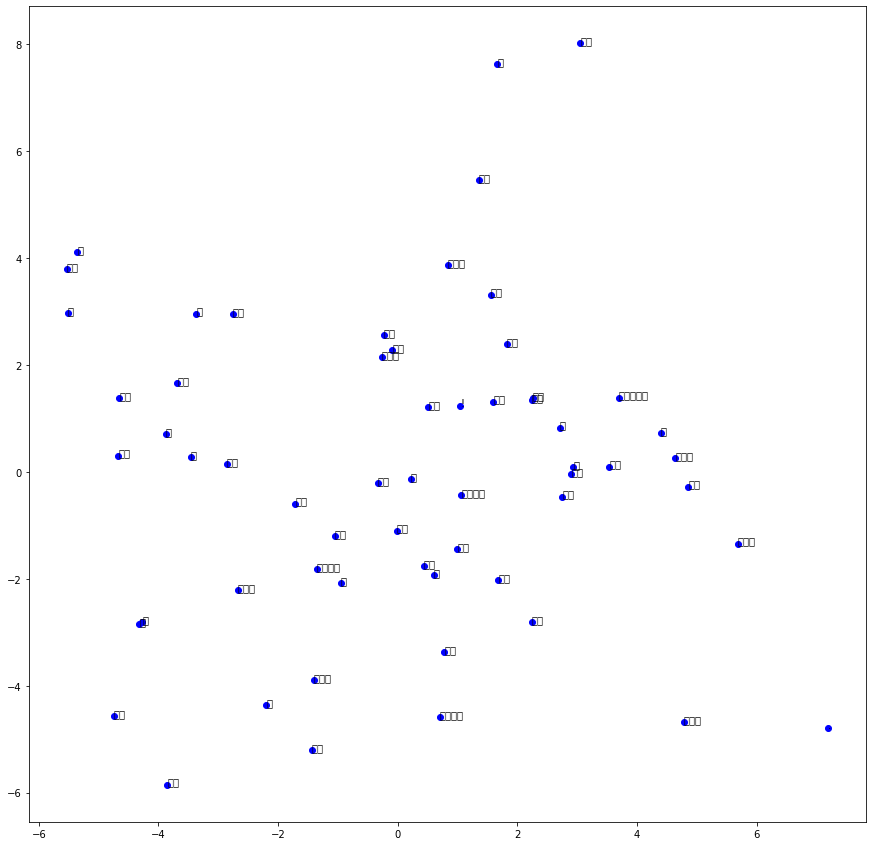

In [31]:
plt.figure(figsize=(15,15))

for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate, y_coordinate))